## ALICE Demo for Film

Code to visualize steps of ALICE software. 

Scroll down to __ALICE Software Steps Demo__ for an _interactive_ demo of the main steps of the ALICE software.

Note: this notebook was made for the purpose of the event that happened on the 6th October 2022.

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import os
from copy import deepcopy
from source_functions.main import *
from source_functions.label_transformation import *
import skimage.io as io

#### Data
Example mask data (of labels and pins) for one specimen.

In [3]:
details = np.load('label_example_info.npy',allow_pickle=True)

#### Image Processing (ALICE Software)

In [2]:
def colour_mask(masks, image, new_col=[255, 0, 0]):
    msk_img = deepcopy(image)
    msk_img[np.where(masks == True)] = new_col
    return msk_img

In [7]:
msk2 = colour_mask(details.item()[0]['mask_l'],details.item()[0]['mask_p'],[0,0,255])

In [8]:
corners = {}

In [12]:
i = 3
use_backup = 0
reconfig_method=0
min_corner_angle=10

if i==3:
    use_backup = 1
    reconfig_method=1
    min_corner_angle=10


msk_pth = deepcopy(details.item()[i]["mask_l"])
img_pth = deepcopy(details.item()[i]["image"])


mask_pin = deepcopy(details.item()[i]["mask_p"])

mask, img_orig, corners_x, corners_y, contours = find_corners(
    msk_pth,
    img_pth,
    ydist=False,
    combine_extra_masks=True,
    paths=False,
    label_method=1,
)


short_inds, long_inds, _, dists_dict = define_label_sides(corners_x, corners_y)

# 3.1) Check corners:
cc = check_corners(
    corners_x, corners_y, short_inds, long_inds, min_angle=min_corner_angle
)
# 3.2) If corners don't fit criteria, redo the corner computation:
if (cc == True) or (use_backup == 1):
    corners_x, corners_y = backup_corner_method(contours)
    short_inds, long_inds, _, dists_dict = define_label_sides(corners_x, corners_y)

# 4) Update corners of parallelogram:
corners_x_updated, corners_y_updated = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x, corners_y, method=reconfig_method
)
# If these new corners are significantly larger than the original corners, we
# use the original corners instead. Check this with compare_corners function:
corners_x_updated2, corners_y_updated2 = compare_corners(
    img_orig, corners_x, corners_y, corners_x_updated, corners_y_updated
)

corners[i] = [corners_x_updated2,corners_y_updated2]

In [13]:
seg_labels = {}

In [14]:
transformed_images = {}

In [18]:
i = 3



short_inds, long_inds, _, dists_dict = define_label_sides(corners[i][0], corners[i][1])
img_warped, _ = perspective_transform(
        corners[i][0],
        corners[i][1],
        details.item()[i]['image'],
        dists_dict,
        short_inds,
        long_inds,
        fixed_dim=False,
        dimension=None,
    )

transformed_images[i] = img_warped
seg_labels[i] = _

In [19]:
template,all_imgs = select_template(list(transformed_images.values()))

In [20]:
opt_angle, _, _, _, _ = adjust_alignment(
    template, np.linspace(-10, 10, 21)
)
template_label = imutils.rotate_bound(template, opt_angle)

In [21]:
aligned_labels = {}
for i,im in enumerate(list(transformed_images.values())):
    img_T = align_image(im, template_label)
    aligned_labels[i]=img_T

In [22]:
pix_diffs = [np.sum(abs(template_label - I)) for I in list(aligned_labels.values())]
pix_diffs_ = [b for b in pix_diffs if b > 0]
ub = np.median(pix_diffs_) + (
    np.percentile(pix_diffs_, 75) - np.percentile(pix_diffs_, 25)
)

merged = merge_label(
    [
        I
        for i, I in enumerate(list(aligned_labels.values()))
        if pix_diffs[i] < ub
    ],
    method=0,
)

In [27]:
thresh = cv2.adaptiveThreshold(cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,2)

In [28]:
results = pytesseract.image_to_string(imutils.rotate_bound(thresh, 180), config='--psm 11 script=Latin')

In [29]:
res = " ".join(re.findall('\w+',results))

In [30]:
res

'Boriador Morona Santiago Cord de Cutnen GK e of Nags a 1 teen 1 roe M Cooper oo'

In [31]:
img = io.imread('/home/arias1/Documents/GitHub/ALICE/tests/good/013612444_additional_top.JPG')

In [48]:
thresh = cv2.adaptiveThreshold(cv2.cvtColor(img[:,30:], cv2.COLOR_BGR2GRAY),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,41,4)

In [49]:
results = pytesseract.image_to_string(imutils.rotate_bound(thresh, 180), config='--psm 11 script=Latin')

In [50]:
res = " ".join(re.findall('\w+',results))

In [51]:
res

'Ecuador Norona Santiago Cord de Cutueu GKe of Macag 4 Aste 1982 M Cooper ire'

In [69]:
newimg = img[:,30:-10]

In [52]:
aligned = align_merged_label(merged)

In [53]:
ocr_best = 'Ecuador, Morona\n\nSantiago,Cord.de\n\nCutueu 6K e of Macas\n\n\n\ni. 1982\nM Cooper'

Text(-40, 15, 'Ecuador, Morona\n\nSantiago,Cord.de\n\nCutueu 6K e of Macas\n\n\n\ni. 1982\nM Cooper')

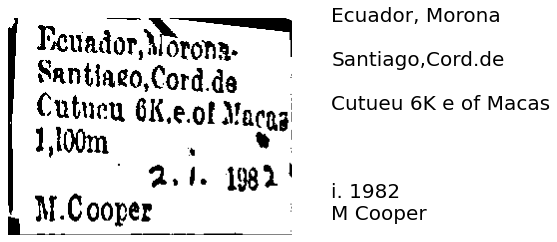

In [54]:
fig,ax = plt.subplots()
ax.imshow(thresh,cmap='gray')
ax.set_ylim([0,np.shape(thresh)[0]])
ax.set_xlim([np.shape(thresh)[1],0])
ax.axis('off')

ax.text(-40, 15,ocr_best,fontsize=20)


### Plotting Functions

In [55]:
def plot1():
    
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(details.item()[0]['image'])

    ax[0,1].imshow(details.item()[1]['image'])

    ax[1,0].imshow(details.item()[2]['image'])

    ax[1,1].imshow(details.item()[3]['image'])

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)


In [56]:
def plot2():
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(colour_mask(details.item()[0]['mask_l'],details.item()[0]['mask_p'],[0,0,255]))

    ax[0,1].imshow(colour_mask(details.item()[1]['mask_l'],details.item()[1]['mask_p'],[0,0,255]))

    ax[1,0].imshow(colour_mask(details.item()[2]['mask_l'],details.item()[2]['mask_p'],[0,0,255]))

    ax[1,1].imshow(colour_mask(details.item()[3]['mask_l'],details.item()[3]['mask_p'],[0,0,255]))

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)


In [57]:
def plot3():
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(details.item()[0]['image'])
    ax[0,0].plot(corners[0][0]+[corners[0][0][0]],corners[0][1]+[corners[0][1][0]],'-k',linewidth=4)

    ax[0,1].imshow(details.item()[1]['image'])
    ax[0,1].plot(corners[1][0]+[corners[1][0][0]],corners[1][1]+[corners[1][1][0]],'-k',linewidth=4)

    ax[1,0].imshow(details.item()[2]['image'])
    ax[1,0].plot(corners[2][0]+[corners[2][0][0]],corners[2][1]+[corners[2][1][0]],'-k',linewidth=4)

    ax[1,1].imshow(details.item()[3]['image'])
    ax[1,1].plot(corners[3][0]+[corners[3][0][0]],corners[3][1]+[corners[3][1][0]],'-k',linewidth=4)

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)
    

In [58]:
def plot4():
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(seg_labels[0])

    ax[0,1].imshow(seg_labels[1])

    ax[1,0].imshow(seg_labels[2])

    ax[1,1].imshow(seg_labels[3])

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)

In [59]:
def plot5():
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(transformed_images[0])

    ax[0,1].imshow(transformed_images[1])

    ax[1,0].imshow(transformed_images[2])

    ax[1,1].imshow(transformed_images[3])

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)

In [73]:
def plot6():
    fig,ax = plt.subplots(2,2,figsize=(12,9))

    ax[0,0].imshow(aligned_labels[0])
    ax[0,0].set_xlim([np.shape(aligned_labels[0])[1],0])
    ax[0,0].set_ylim([0,np.shape(aligned_labels[0])[0]])

    ax[0,1].imshow(aligned_labels[1])
    ax[0,1].set_xlim([np.shape(aligned_labels[1])[1],0])
    ax[0,1].set_ylim([0,np.shape(aligned_labels[1])[0]])

    ax[1,0].imshow(aligned_labels[2])
    ax[1,0].set_xlim([np.shape(aligned_labels[2])[1],0])
    ax[1,0].set_ylim([0,np.shape(aligned_labels[2])[0]])

    ax[1,1].imshow(aligned_labels[3])
    ax[1,1].set_xlim([np.shape(aligned_labels[3])[1],0])
    ax[1,1].set_ylim([0,np.shape(aligned_labels[3])[0]])
    

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)

In [61]:
def plot7():
    fig,ax = plt.subplots(figsize=(6,5))
    ax.imshow(newimg)
    ax.set_ylim([0,np.shape(newimg)[0]])
    ax.set_xlim([np.shape(newimg)[1],0])
    ax.axis('off')

In [62]:
def plot8():
    fig,ax = plt.subplots()
    ax.imshow(thresh,cmap='gray')
    ax.set_ylim([0,np.shape(thresh)[0]])
    ax.set_xlim([np.shape(thresh)[1],0])
    ax.axis('off')
    ax.text(-40, 15,ocr_best,fontsize=20)

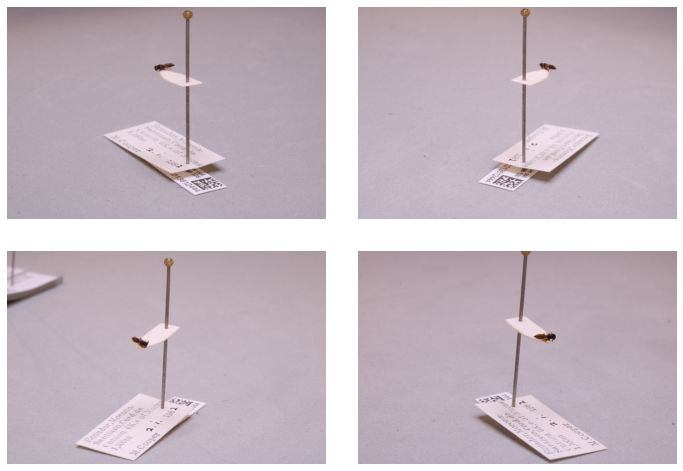

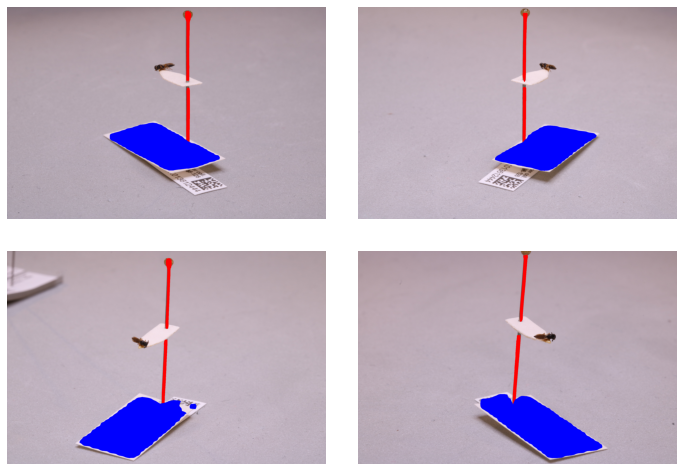

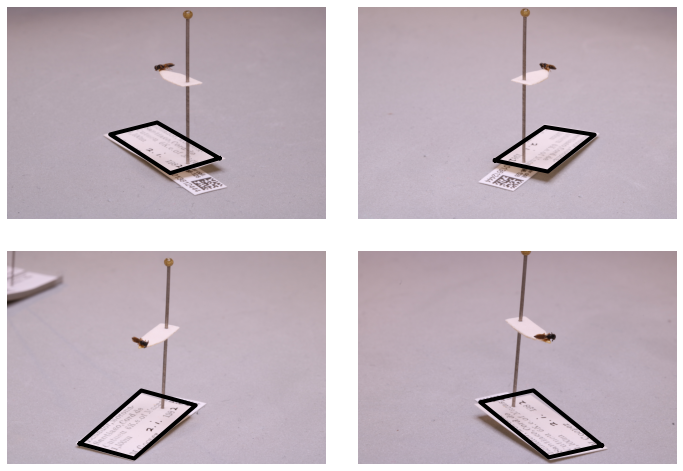

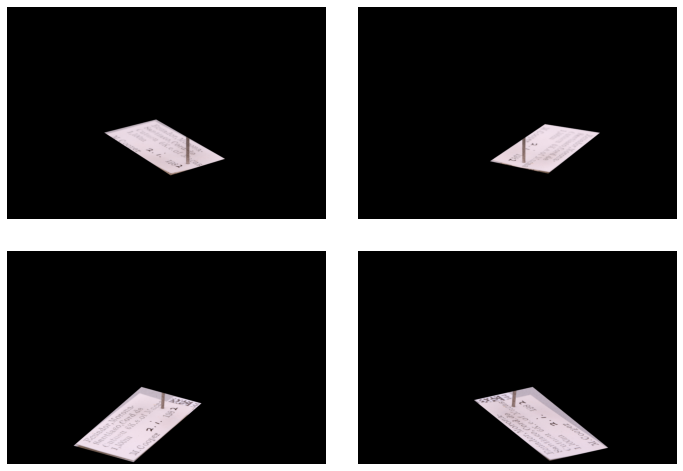

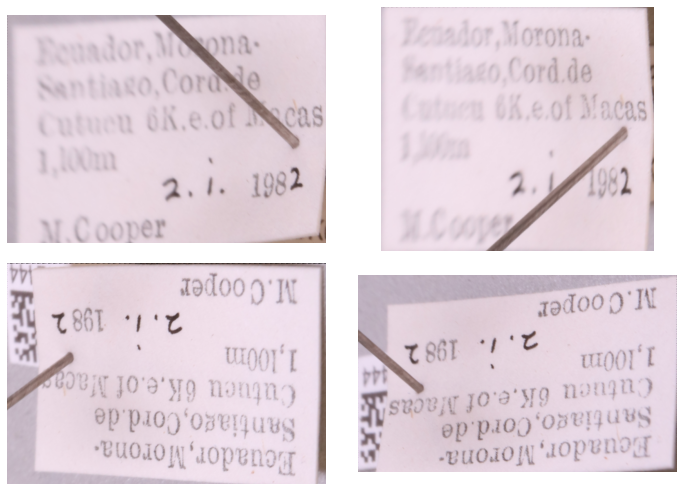

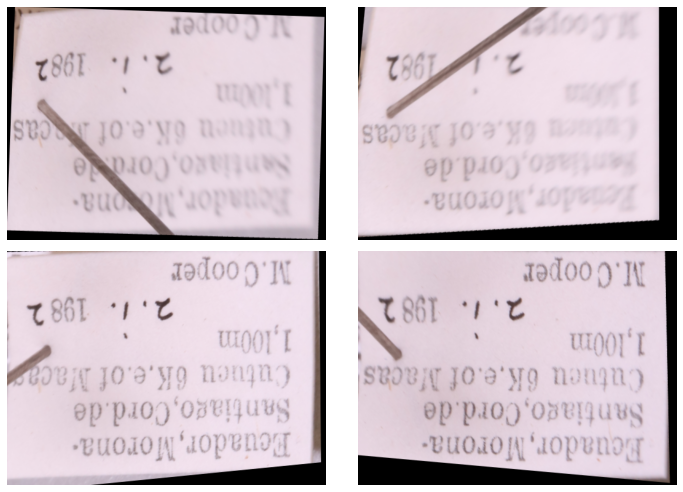

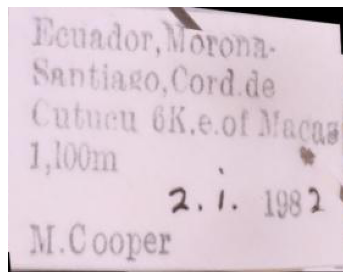

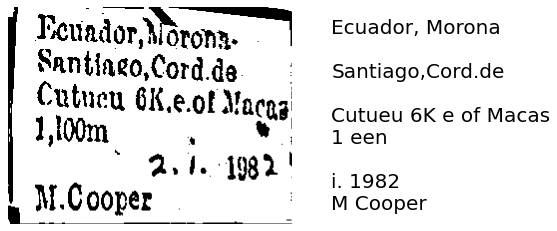

In [487]:
plot1()
plt.savefig('plot1.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot2()
plt.savefig('plot2.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot3()
plt.savefig('plot3.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot4()
plt.savefig('plot4.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot5()
plt.savefig('plot5.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot6()
plt.savefig('plot6.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot7()
plt.savefig('plot7.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

plot8()
plt.savefig('plot8.png',dpi=600,bbox_inches='tight',pad_inches=0.05)

# ALICE Software Steps Demo

In [461]:
specimen_id = '013612444'

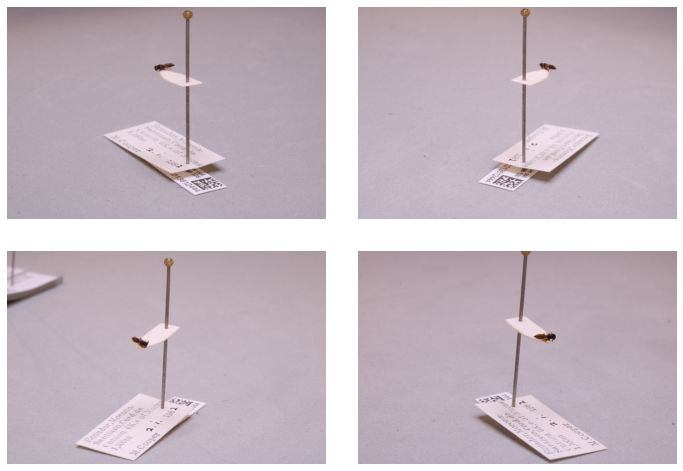

In [462]:
plot1()

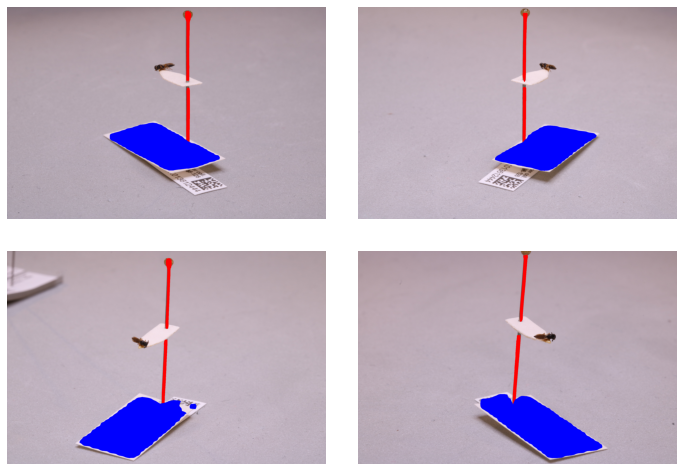

In [463]:
plot2()

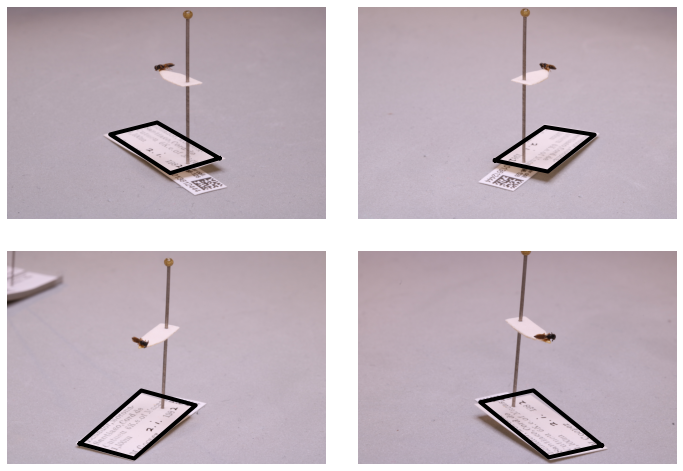

In [464]:
plot3()

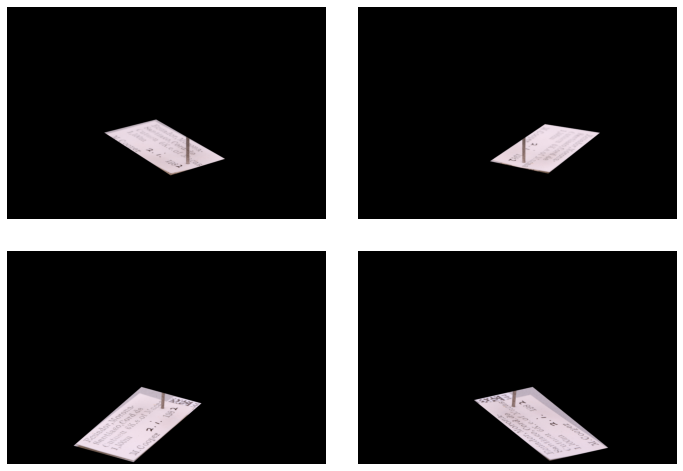

In [465]:
plot4()

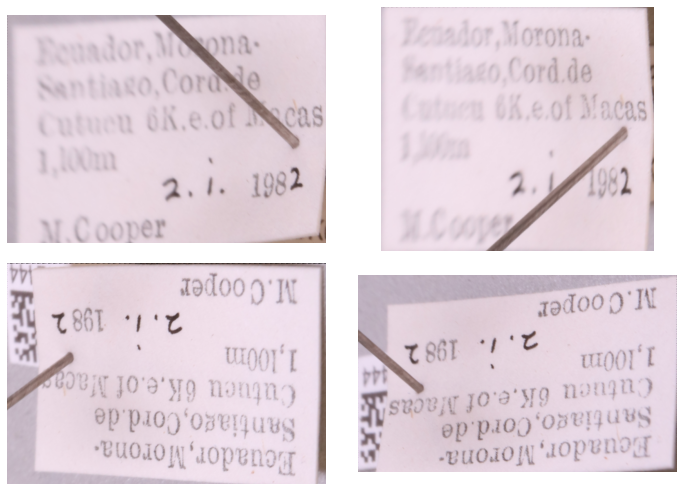

In [466]:
plot5()

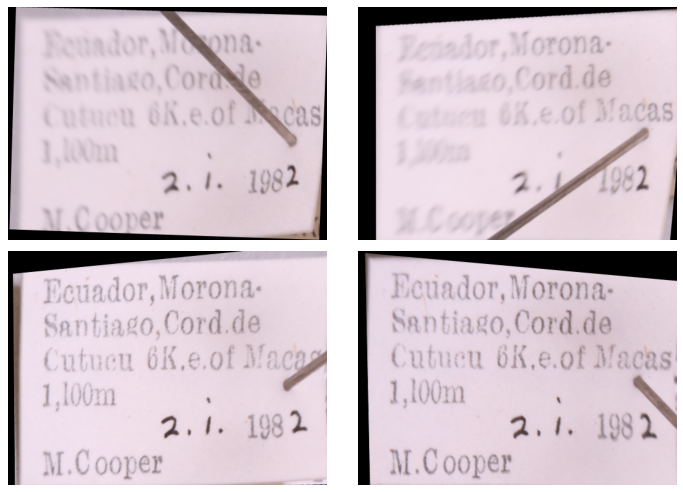

In [76]:
plot6()

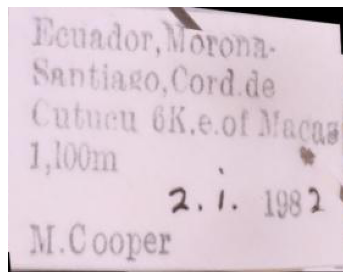

In [468]:
plot7()

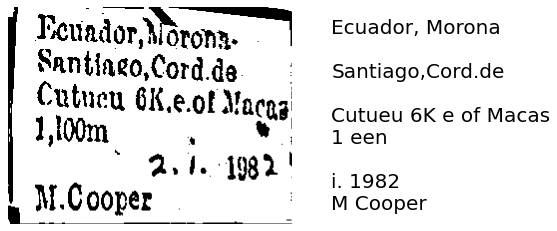

In [469]:
plot8()

### Interactive Steps Demo

In [63]:
def ALICE():
    v = input()
    if v == 'step 0':
        plot1()
        plt.show()
        v = input()
        
    if v == 'step 1':
        plot2()
        plt.show()
        v = input()
    if v == 'step 2':
        plot3()
        plt.show()
        v = input()
        
    if v == 'step 3':
        plot4()
        plt.show()
        v = input()
        
    if v == 'step 4':
        plot5()
        plt.show()
        v = input()

    if v == 'step 5':
        plot6()
        plt.show()
        v = input()
        
    if v == 'step 6':
        plot7()
        plt.show()
        v = input()
        
    if v == 'step 7':
        plot8()
        plt.show()

step 0


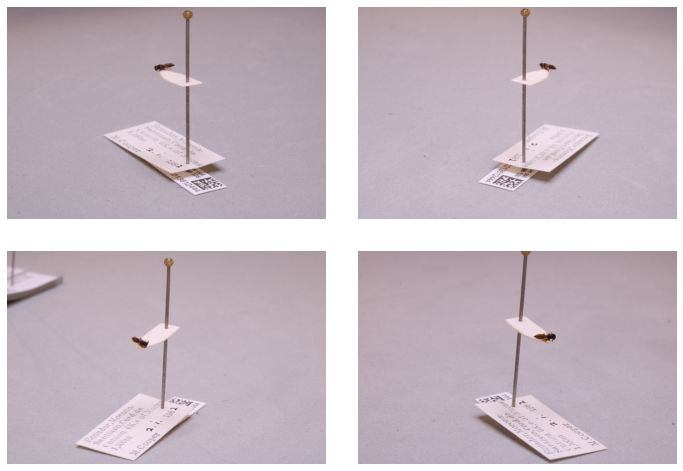

step 7


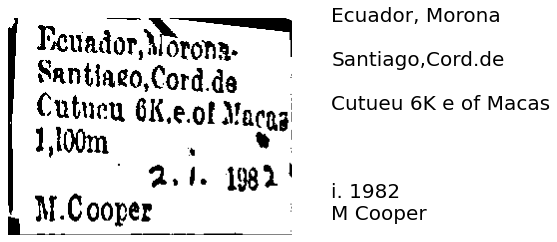

In [77]:
ALICE()